In [1]:
from pandemic.learning.environment import PandemicEnvironment
from pandemic.learning.transition import ReplayMemory
from pandemic.learning.transition import Transition
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F


env = PandemicEnvironment(num_epidemic_cards=4, characters=(5,7))

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
def net(n_in, n_out, n_h):
    return nn.Sequential(nn.Linear(n_in, n_h),
                     nn.ReLU(),
                     nn.Linear(n_h, n_out),
                     nn.Sigmoid())

In [3]:
class DQN(nn.Module):

    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # I don't know what a fucking conv net is...
        linear_input_size = inputs
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [4]:
BATCH_SIZE = 512
EPS_START = 0.9
EPS_END = \
    0.05
EPS_DECAY = 20000
TARGET_UPDATE = 10
GAMMA = 0.999
PLOT_STEPS=10


# Get number of actions from gym action space
action_space_dim = env.action_space.shape[0]

# no screen
obs_space_dim = env.observation_space.shape[0] + action_space_dim



policy_net = net(obs_space_dim, action_space_dim, 1000).to(device)
target_net = net(obs_space_dim, action_space_dim, 1000).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0

def random_action(action_space):
    idx_nonzero = np.nonzero(action_space)[0]
    return np.random.choice(idx_nonzero)

def select_random_action(action_space):
     return torch.tensor([[random_action(action_space)]], device=device, dtype=torch.long)

def select_action(state, action_space):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            policy_out = policy_net(state)
            return policy_out.max(1)[1].view(1, 1)
    else:
        # select random non zero value from action space
        return torch.tensor([[random_action(action_space)]], device=device, dtype=torch.long)


episode_durations = []
episode_reward = []
episode_loss = []


def plot_timeline(ax, np_arr, name):
    arr_t = torch.tensor(np_arr, dtype=torch.float)
    ax.set_xlabel('Episode')
    ax.set_ylabel(name)
    ax.plot(arr_t.numpy())
    # Take 100 episode averages and plot them too
    if len(arr_t) >= 100:
        means = arr_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax.plot(means.numpy())

def plot_durations():
    fig, axs = plt.subplots(3,1, figsize=(16,12))
#     plt.title('Training...')
#     plt.clf()
    plot_timeline(axs[0], episode_durations, "Steps")
        
    plot_timeline(axs[1], episode_loss, "Loss")
    plot_timeline(axs[2], episode_reward, "Reward")
    plt.show()
    plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())

def get_state(env):
    return torch.from_numpy(np.concatenate((env.observation_space, env.action_space), axis=None)).float().view(1,obs_space_dim)

def step(state):
    # Select and perform an action
    action = select_action(state, env.action_space)
    _, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device).float()

    # Observe new state
    if not done:
        next_state = get_state(env)
    else:
        print("reward: ", reward)
        next_state = None

    # Store the transition in memory
    memory_push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the target network)
    optimize_model(done)
    if done:
        episode_durations_append(t + 1)
        episode_reward_append(reward)
        if i_episode % PLOT_STEPS == 0:
            env.render()
            plot_durations()
    return done

In [5]:
def optimize_model(done):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    if done:
        episode_loss.append(loss)
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # maybe not
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [6]:
# run random games for a while to quickly fill up memory
env.reset()
memory_push = memory.push
state = get_state(env)
for t in range(5000):
    # Select and perform an action
    action = select_random_action(env.action_space)
    _, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device).float()

    # Observe new state
    if not done:
        next_state = get_state(env)
    else:
        print("reward: ", reward)
        next_state = None

    # Store the transition in memory
    memory_push(state, action, next_state, reward)

    # Move to the next state
    state = next_state
    if done:
        env.reset()
        state = get_state(env)

reward:  tensor([0.1068])
reward:  tensor([0.0940])
reward:  tensor([-0.5370])
reward:  tensor([-0.8231])
reward:  tensor([0.1120])
reward:  tensor([-0.8111])
reward:  tensor([-1.1800])
reward:  tensor([0.0048])
reward:  tensor([-0.6489])
reward:  tensor([-0.3313])
reward:  tensor([-0.6769])
reward:  tensor([-0.8492])
reward:  tensor([-0.8701])
reward:  tensor([-0.2340])
reward:  tensor([-0.5118])
reward:  tensor([-0.6439])
reward:  tensor([-0.8452])
reward:  tensor([-1.0140])
reward:  tensor([-0.5679])
reward:  tensor([0.0969])
reward:  tensor([0.1009])
reward:  tensor([-0.8311])
reward:  tensor([-0.8542])
reward:  tensor([-0.8351])
reward:  tensor([-0.8191])
reward:  tensor([-0.8322])
reward:  tensor([-1.0070])
reward:  tensor([-0.5149])
reward:  tensor([-0.2330])
reward:  tensor([0.1059])
reward:  tensor([-0.2160])
reward:  tensor([-0.6779])
reward:  tensor([-0.8300])
reward:  tensor([0.1108])
reward:  tensor([-0.8252])
reward:  tensor([-1.1810])
reward:  tensor([-0.3482])
reward:  

reward:  tensor([-0.1909])
Airlift(player=5, target_player=5, destination=15) 0.01491110011343777
ResilientPopulation(player=7, discard_city=42) 0.01591110011343777
DriveFerry(player=5, destination=30) 0.016911100113437768
DriveFerry(player=5, destination=36) 0.01791110011343777
DriveFerry(player=5, destination=1) 0.01891110011343777
DriveFerry(player=5, destination=8) 0.019911100113437767
Wait 0.024002241994572453
Wait 0.024002241994572453
Wait 0.024002241994572453
Wait 0.024002241994572453
DirectFlight(player=7, destination=3) 0.01804669193785357
DriveFerry(player=7, destination=8) 0.01904669193785357
DirectFlight(player=7, destination=27) 0.02004669193785357
DirectFlight(player=7, destination=15) 0.021046691937853572
Wait 0.021046691937853572
Wait 0.028002241994572456
Wait 0.028002241994572456
Wait 0.028002241994572456
DirectFlight(player=5, destination=47) 0.024911100113437768
DriveFerry(player=5, destination=41) 0.02591110011343777
DriveFerry(player=5, destination=5) 0.02691110011

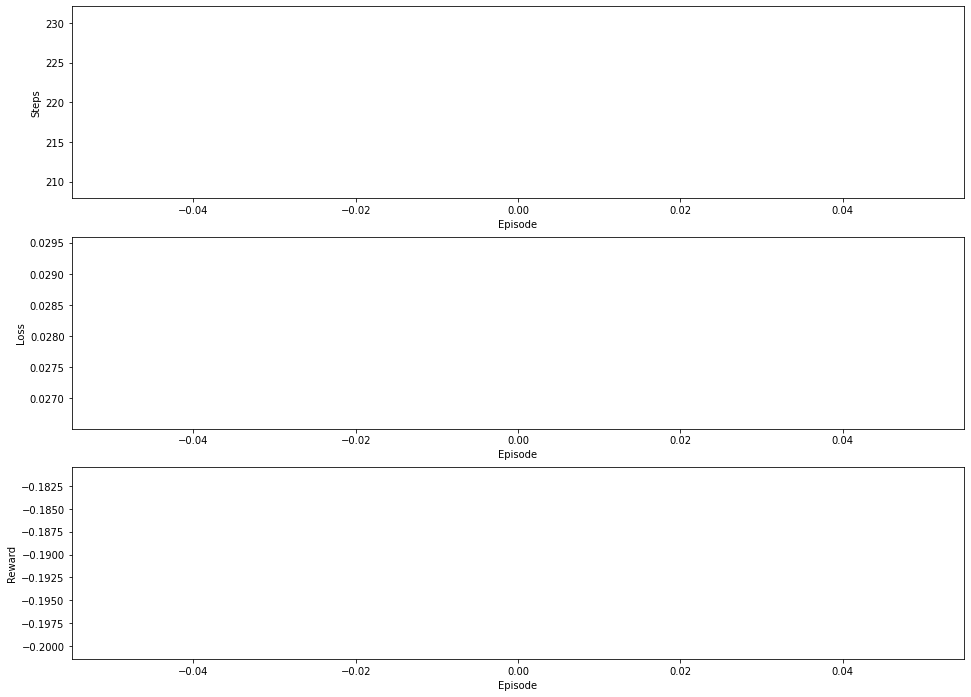

reward:  tensor([-0.8421])
reward:  tensor([-0.5240])
reward:  tensor([-0.0788])
reward:  tensor([-0.6289])
reward:  tensor([-0.5159])
reward:  tensor([-0.3713])
reward:  tensor([-0.1050])
reward:  tensor([-0.9608])
reward:  tensor([-0.9722])
reward:  tensor([-0.8261])
DirectFlight(player=5, destination=19) 0.01491110011343777
DirectFlight(player=5, destination=15) 0.01591110011343777
DriveFerry(player=5, destination=3) 0.016911100113437768
DirectFlight(player=5, destination=40) 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.024866650170156653
Wait 0.024866650170156653
Wait 0.024866650170156653
DriveFerry(player=7, destination=29) 0.025866650170156654
DirectFlight(player=7, destination=32) 0.019911100113437767
DriveFerry(player=7, destination=46) 0.020911100113437768
DirectFlight(player=7, destination=34) 0.014955550056718885
Wait 0.014955550056718885
Wait 0.014955550056718885
Forecast(player=7) 0.015955550056718885
ChooseCard(player=7, card=33) 0.01695555

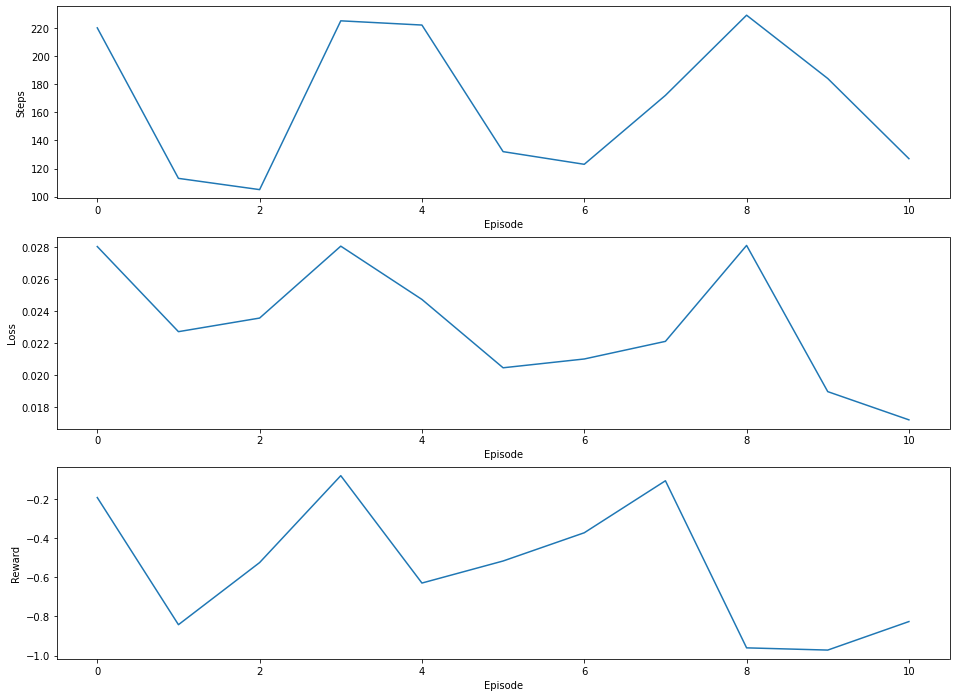

reward:  tensor([-0.6468])
reward:  tensor([-0.8622])
reward:  tensor([-0.8241])
reward:  tensor([-0.0879])
reward:  tensor([-0.0162])
reward:  tensor([0.0870])
reward:  tensor([-0.3054])
reward:  tensor([-1.0001])
reward:  tensor([-0.9721])
reward:  tensor([-0.9781])
ResilientPopulation(player=7, discard_city=43) 0.007955550056718885
DriveFerry(player=5, destination=29) 0.008955550056718884
CharterFlight(player=5, destination=25) 0.003
DriveFerry(player=5, destination=44) 0.004
DriveFerry(player=5, destination=16) 0.005
Wait 0.011955550056718885
Wait 0.01604669193785357
Wait 0.01604669193785357
Wait 0.01604669193785357
DirectFlight(player=7, destination=43) 0.01704669193785357
TreatDisease(city=43, target_virus=1) 0.01804669193785357
DriveFerry(player=7, destination=32) 0.01904669193785357
DriveFerry(player=7, destination=43) 0.02004669193785357
Wait 0.027002241994572455
Wait 0.027002241994572455
Wait 0.027002241994572455
Wait 0.027002241994572455
DirectFlight(player=5, destination=17

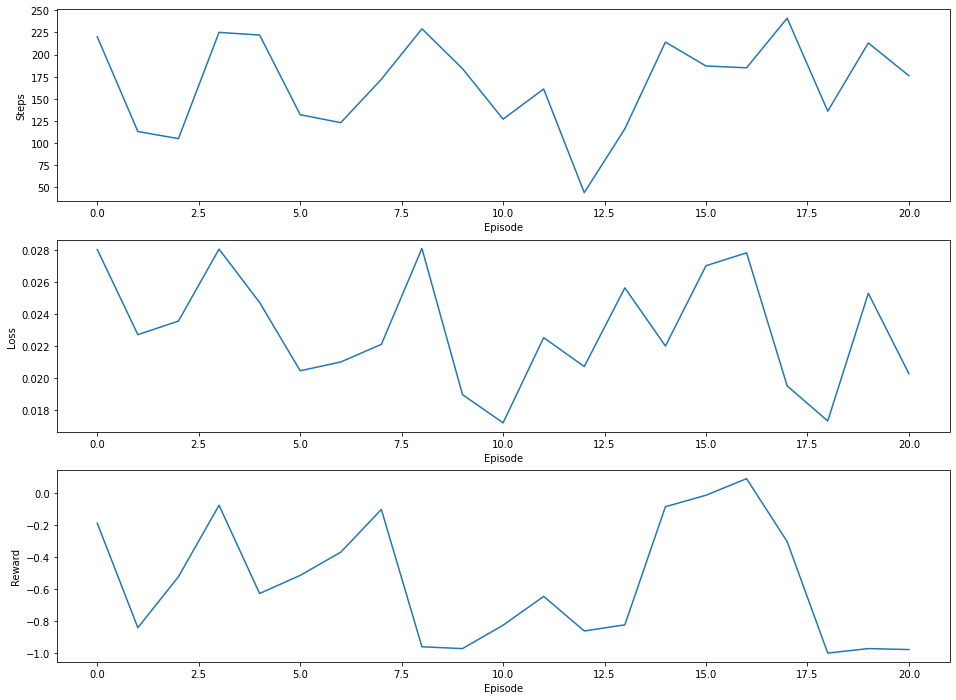

reward:  tensor([-0.8762])
reward:  tensor([-0.6389])
reward:  tensor([-0.3504])
reward:  tensor([-0.8111])
reward:  tensor([-0.2670])
reward:  tensor([-0.4890])
reward:  tensor([0.0999])
reward:  tensor([0.1108])
reward:  tensor([-0.4870])
reward:  tensor([-0.8390])
ResilientPopulation(player=5, discard_city=15) 0.007955550056718885
DirectFlight(player=5, destination=31) 0.008955550056718884
DriveFerry(player=5, destination=48) 0.009955550056718884
DirectFlight(player=5, destination=22) 0.010955550056718884
DriveFerry(player=5, destination=19) 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
Wait 0.011955550056718885
DirectFlight(player=7, destination=10) 0.012955550056718885
DriveFerry(player=7, destination=2) 0.013955550056718884
DirectFlight(player=7, destination=11) 0.014955550056718885
DirectFlight(player=7, destination=27) 0.009000000000000001
Wait 0.009000000000000001
Airlift(player=7, target_player=7, destination=8) 0.01
Wait 0

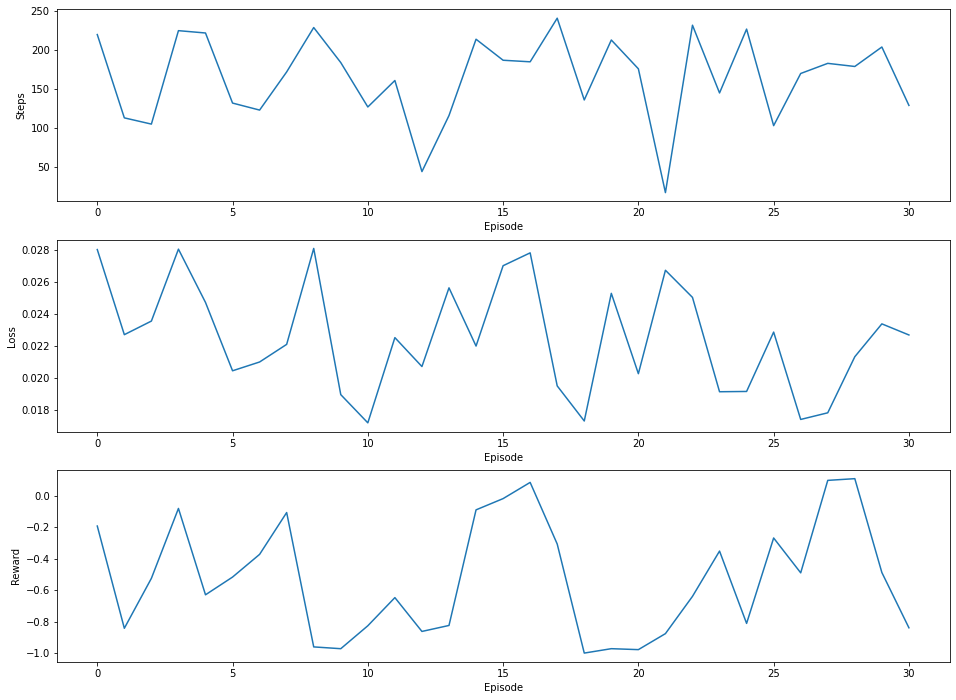

reward:  tensor([0.0849])
reward:  tensor([-0.2151])
reward:  tensor([-0.9780])
reward:  tensor([-0.8321])
reward:  tensor([-0.8041])
reward:  tensor([-0.5609])
reward:  tensor([0.0109])
reward:  tensor([0.0990])
reward:  tensor([-0.2160])
reward:  tensor([0.1110])
DirectFlight(player=5, destination=37) 0.01491110011343777
DirectFlight(player=5, destination=25) 0.008955550056718884
DriveFerry(player=5, destination=38) 0.009955550056718884
DirectFlight(player=5, destination=23) 0.010955550056718884
Wait 0.010955550056718884
Wait 0.01791110011343777
Wait 0.01791110011343777
Wait 0.01791110011343777
DirectFlight(player=7, destination=26) 0.01891110011343777
DriveFerry(player=7, destination=40) 0.019911100113437767
DriveFerry(player=7, destination=7) 0.020911100113437768
DirectFlight(player=7, destination=28) 0.014955550056718885
Wait 0.02191110011343777
Wait 0.02191110011343777
Wait 0.02191110011343777
Wait 0.02191110011343777
DriveFerry(player=5, destination=6) 0.02291110011343777
Direct

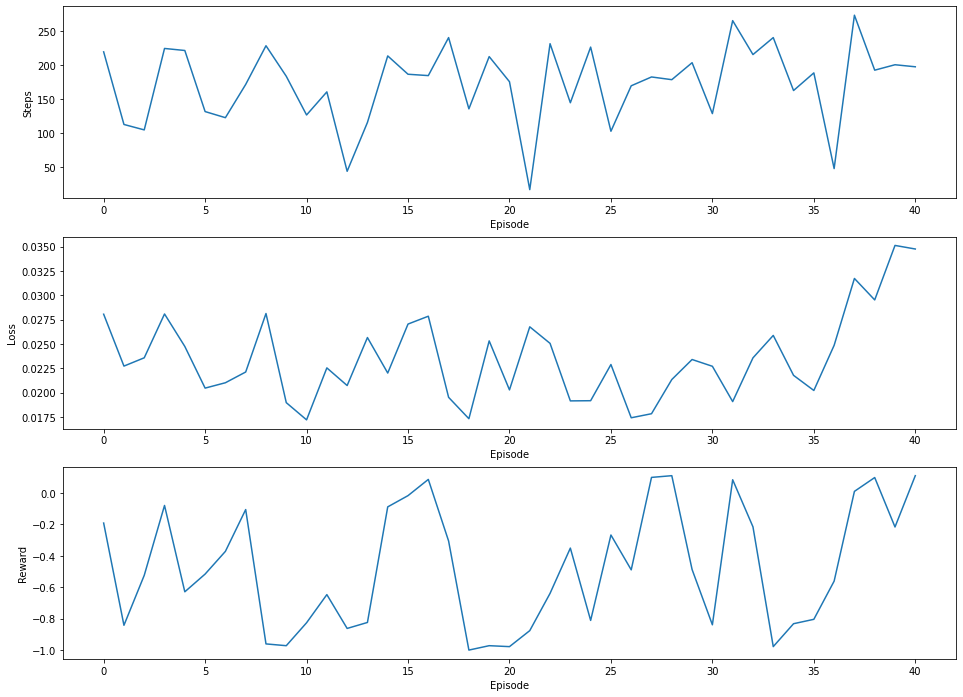

reward:  tensor([-0.8581])
reward:  tensor([-0.8111])
reward:  tensor([-0.7922])
reward:  tensor([-0.2110])
reward:  tensor([0.0930])
reward:  tensor([-0.0868])
reward:  tensor([-0.8201])
reward:  tensor([-0.3652])
reward:  tensor([-0.4980])
reward:  tensor([0.1010])
GovernmentGrant(player=7, target_city=4) 0.01204669193785357
Airlift(player=7, target_player=5, destination=16) 0.01304669193785357
ResilientPopulation(player=5, discard_city=17) 0.01404669193785357
DriveFerry(player=5, destination=44) 0.01504669193785357
DirectFlight(player=5, destination=5) 0.011955550056718885
DirectFlight(player=5, destination=27) 0.006
DriveFerry(player=5, destination=45) 0.007
Wait 0.013955550056718884
Wait 0.013955550056718884
Wait 0.013955550056718884
Wait 0.013955550056718884
DriveFerry(player=7, destination=48) 0.014955550056718885
DirectFlight(player=7, destination=18) 0.015955550056718885
DriveFerry(player=7, destination=37) 0.016955550056718886
DriveFerry(player=7, destination=8) 0.01795555005

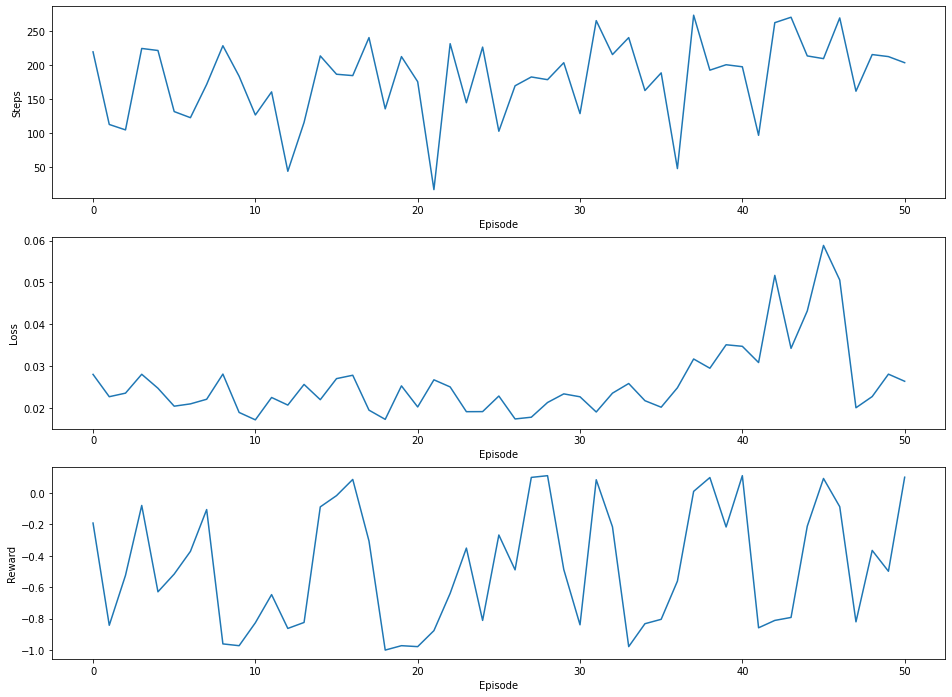

reward:  tensor([-0.8352])
reward:  tensor([0.0810])
reward:  tensor([0.0849])
reward:  tensor([-0.1029])
reward:  tensor([-0.1349])
reward:  tensor([-0.1270])
reward:  tensor([-1.0020])
reward:  tensor([-0.3833])
reward:  tensor([-0.1309])
reward:  tensor([-1.0201])
DirectFlight(player=5, destination=45) 0.01491110011343777
DriveFerry(player=5, destination=35) 0.01591110011343777
DriveFerry(player=5, destination=45) 0.016911100113437768
DriveFerry(player=5, destination=27) 0.01791110011343777
Wait 0.024866650170156653
Wait 0.024866650170156653
Wait 0.024866650170156653
Wait 0.024866650170156653
DirectFlight(player=7, destination=26) 0.025866650170156654
DirectFlight(player=7, destination=3) 0.019911100113437767
DriveFerry(player=7, destination=18) 0.020911100113437768
DriveFerry(player=7, destination=33) 0.02191110011343777
Wait 0.02191110011343777
Wait 0.028866650170156653
Wait 0.028866650170156653
Wait 0.028866650170156653
DirectFlight(player=5, destination=28) 0.029866650170156654


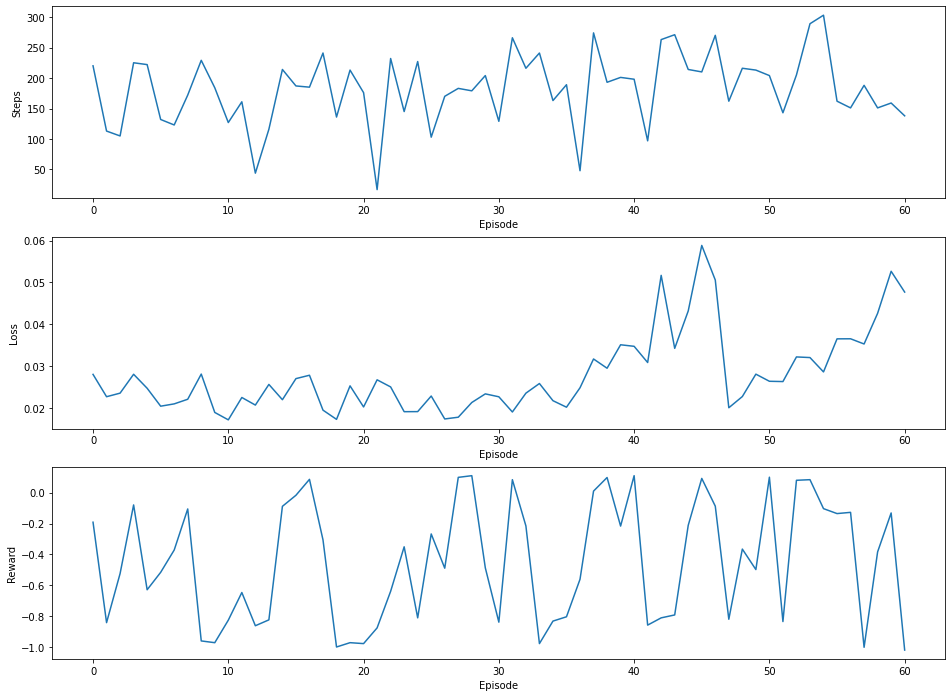

reward:  tensor([-0.8090])
reward:  tensor([-0.4093])
reward:  tensor([-0.6909])
reward:  tensor([0.1040])
reward:  tensor([-0.2361])
reward:  tensor([-0.3433])
reward:  tensor([-0.0839])
reward:  tensor([0.0079])
reward:  tensor([-0.1359])
reward:  tensor([-0.6719])
Airlift(player=5, target_player=7, destination=9) 0.007955550056718885
DirectFlight(player=5, destination=15) 0.008955550056718884
DriveFerry(player=5, destination=1) 0.009955550056718884
DirectFlight(player=5, destination=19) 0.004
DriveFerry(player=5, destination=20) 0.005
Wait 0.011955550056718885
Wait 0.011955550056718885
GovernmentGrant(player=5, target_city=28) 0.012955550056718885
Wait 0.012955550056718885
DirectFlight(player=7, destination=4) 0.013955550056718884
DriveFerry(player=7, destination=14) 0.014955550056718885
DirectFlight(player=7, destination=10) 0.015955550056718885
DriveFerry(player=7, destination=38) 0.016955550056718886
Wait 0.016955550056718886
Wait 0.02391110011343777
Wait 0.02391110011343777
Wait

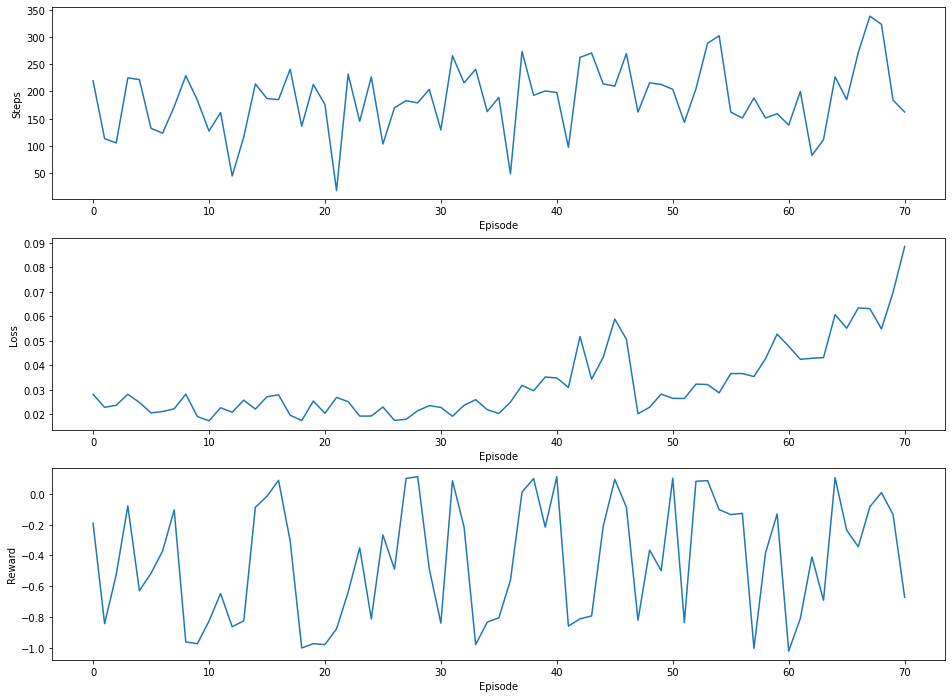

reward:  tensor([0.0999])
reward:  tensor([-0.6769])
reward:  tensor([-0.3773])
reward:  tensor([-1.0030])
reward:  tensor([-0.0432])
reward:  tensor([-1.0420])
reward:  tensor([-0.9700])
reward:  tensor([0.1001])
reward:  tensor([-0.8332])
reward:  tensor([-0.8371])
CharterFlight(player=5, destination=12) 0.001
DriveFerry(player=5, destination=30) 0.002
DirectFlight(player=5, destination=36) 0.003
TreatDisease(city=36, target_virus=1) 0.004
Wait 0.004
Wait 0.010955550056718884
Wait 0.010955550056718884
Wait 0.010955550056718884
DirectFlight(player=7, destination=15) 0.011955550056718885
DirectFlight(player=7, destination=44) 0.012955550056718885
DirectFlight(player=7, destination=10) 0.013955550056718884
DriveFerry(player=7, destination=28) 0.014955550056718885
Wait 0.014955550056718885
Wait 0.014955550056718885
Wait 0.014955550056718885
Wait 0.014955550056718885
DirectFlight(player=5, destination=23) 0.009000000000000001
DirectFlight(player=5, destination=25) 0.01
DirectFlight(player

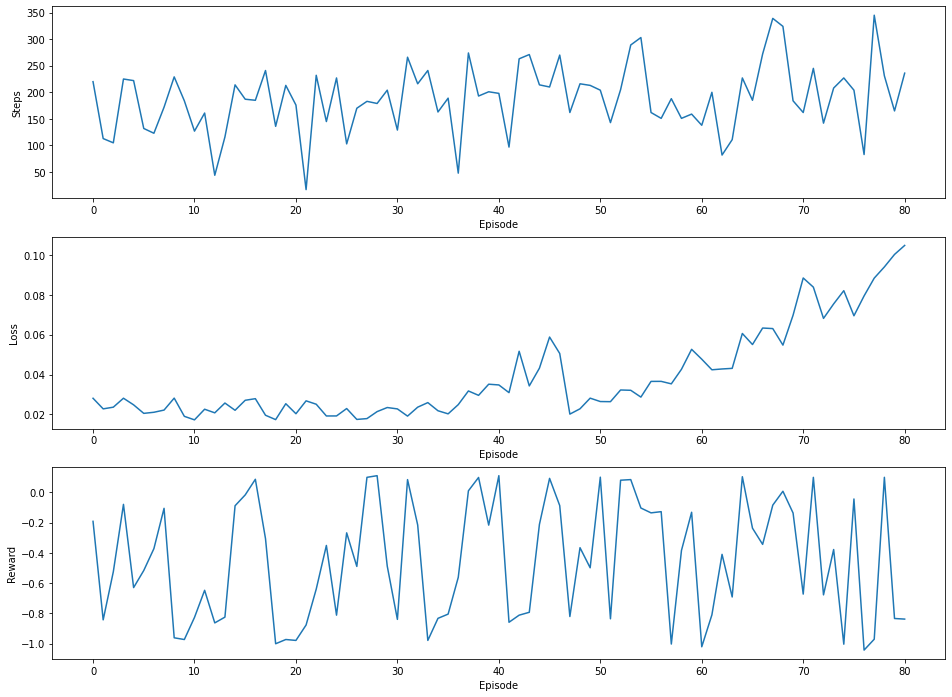

reward:  tensor([0.0830])
reward:  tensor([-0.0868])


KeyboardInterrupt: 

In [7]:
num_episodes = 1000
memory_push = memory.push
episode_durations_append = episode_durations.append
episode_reward_append = episode_reward.append

for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    state = get_state(env)
    for t in count():
        # Select and perform an action
        action = select_action(state, env.action_space)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device).float()

        # Observe new state
        if not done:
            next_state = get_state(env)
        else:
            print("reward: ", reward)
            next_state = None

        # Store the transition in memory
        memory_push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model(done)
        if done:
            episode_durations_append(t + 1)
            episode_reward_append(reward)
            if i_episode % PLOT_STEPS == 0:
                env.render()
                plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
